In [0]:
# # Generic restart command
dbutils.library.restartPython()

In [0]:
!free -m

               total        used        free      shared  buff/cache   available
Mem:          249480       16876      232488           0         114      232603
Swap:          10239           0       10239


# CRC Risk Prediction - Iterative Model Training - Mercy PCP only
 
## Objectives
1. Load cleaned features (170 features from herald_eda_train_wide_cleaned) with identified features removed
2. Create pure temporal train/val/test split
3. Train next generation iterative XGBoost model
4. Compute SHAP values for feature importance ranking
5. Identify features to be removed

## Handling Prevalent Case Bias

**The Problem**: Early cohort quarters (Q0-Q2) have 70% higher event rates due to 
prevalent cases being diagnosed. This creates severe distribution shift in temporal splits.

**Our Solution**: Pure patient-level split with quarter stratification
- Each patient assigned to exactly ONE split (train/val/test)
- Prevents memorization of patient-specific temporal patterns
- Stratify by quarter AND outcome to balance prevalent/incident cases
- No data leakage between splits

**Version 2.0**: Corrected methodology to prevent patient memorization


## ITERATION TRACKING

**Update these variables each iteration:**

In [0]:
# ============================================================================
# ITERATION CONFIGURATION - UPDATE EACH ITERATION
# ============================================================================

ITERATION_NUMBER = 1  # INCREMENT THIS EACH ITERATION (1 = baseline with all features)

FEATURES_REMOVED_THIS_ROUND = [
    # List features removed in THIS iteration
    # Leave empty for iteration 1 (baseline with all features)
    # Example for later iterations:
    # 'V_DAYS_SINCE_WEIGHT',
    # 'OM_HORMONE_THERAPY_DAYS_SINCE',
]

print("="*70)
print(f"ITERATION #{ITERATION_NUMBER}")
print("="*70)
if FEATURES_REMOVED_THIS_ROUND:
    print(f"Features removed this round: {len(FEATURES_REMOVED_THIS_ROUND)}")
    for feat in FEATURES_REMOVED_THIS_ROUND:
        print(f"  - {feat}")
else:
    if ITERATION_NUMBER == 1:
        print("Baseline iteration - using all features")
    else:
        print("No new features removed (continuation run)")
print("="*70)

ITERATION #1
Baseline iteration - using all features


In [0]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json

from sklearn.metrics import (
    precision_recall_curve, roc_curve, auc, 
    average_precision_score, roc_auc_score, 
    brier_score_loss, confusion_matrix
)
from sklearn.model_selection import train_test_split, StratifiedKFold  # Add StratifiedKFold
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import calibration_curve


from xgboost import XGBClassifier
import shap

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col

spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.session.timeZone", "America/Chicago")

trgt_cat = os.environ.get('trgt_cat')
spark.sql('USE CATALOG prod;')

print("="*70)
print("ENVIRONMENT INITIALIZED")
print("="*70)
print(f"Timestamp: {datetime.now()}")
print(f"Spark version: {spark.version}")
print("="*70)

ENVIRONMENT INITIALIZED
Timestamp: 2025-10-16 21:52:59.795635
Spark version: 3.5.0


In [0]:
# Create required directories
directories = [
    'iteration_xgboost_models', 
    'iteration_xgboost_model_metadatas', 
    'iteration_isotonic_calibrators', 
    'iteration_removal_candidates',
    'iteration_deferred_features'
]
for directory in directories:
    os.makedirs(directory, exist_ok=True)
print(f"✓ Created/verified {len(directories)} output directories")

✓ Created/verified 5 output directories


## Step 1: Load Data with Explicit SQL Query

Features are listed by cohort rather than source to aid in feature removal. We will use the cohorts created by the Hierarchal Feature Clustering workbook that used Spearman correlation as its metric.

In [0]:
print("="*70)
print("LOADING DATA")
print("="*70)

# Load data from Spark
df_spark = spark.sql('''
SELECT 
PAT_ID,
END_DTTM,
FUTURE_CRC_EVENT,

ICD_FHX_FIRST_DEGREE_CRC, -- 1

ICD_HIGH_RISK_FHX_FLAG, -- 2

RACE_BLACK_OR_AFRICAN_AMERICAN, -- 3
RACE_CAUCASIAN, -- 3

RACE_OTHER, -- 4

RACE_HISPANIC, -- 5

RACE_ASIAN, -- 6

OM_HORMONE_THERAPY_RECENCY, -- 7

IM_HORMONE_THERAPY_RECENCY, -- 8

OM_HEMORRHOID_MEDS_FLAG, -- 9
OM_HEMORRHOID_MEDS_RECENCY, -- 9
OM_HEMORRHOID_RISK_SCORE, -- 9

IM_HEMORRHOID_MEDS_FLAG, -- 10

PROC_ANAL_PATHOLOGY_FLAG, -- 11

LAB_ANY_TUMOR_MARKER, -- 12
LAB_CEA_ELEVATED_FLAG, -- 12
LAB_CEA_MAX_12MO, -- 12
LAB_CEA_VALUE, -- 12

LAB_CA125_VALUE, -- 13

LAB_HEMOGLOBIN_ACCELERATING_DECLINE, -- 14

LAB_PLATELETS_ACCELERATING_RISE, -- 15

V_BP_SYSTOLIC, -- 16
V_HYPERTENSION_FLAG, -- 16
V_PULSE_PRESSURE, -- 16

V_PULSE, -- 17
V_TACHYCARDIA_FLAG, -- 17

V_FEVER_FLAG, -- 18

OM_ANTISPASMODIC_USE_RECENCY, -- 19

IM_ANTISPASMODIC_USE_RECENCY, -- 20

LAB_COMPREHENSIVE_IRON_DEFICIENCY, -- 21
LAB_IRON_DEFICIENCY_ANEMIA_FLAG, -- 21

LAB_IRON_SATURATION_PCT, -- 22

LAB_FERRITIN_VALUE, -- 23

V_ABNORMAL_WEIGHT_PATTERN, -- 24
V_RAPID_WEIGHT_LOSS_FLAG, -- 24

V_BMI_CHANGE_6M, -- 25
V_WEIGHT_CHANGE_PCT_6M, -- 25
V_WEIGHT_LOSS_SEVERITY, -- 25

V_MAX_WEIGHT_LOSS_PCT_60D, -- 26
V_WEIGHT_TRAJECTORY_SLOPE, -- 26

V_WEIGHT_LOSS_10PCT_6M, -- 27

IS_FEMALE, -- 28

LAB_PLATELETS_VALUE, -- 29

LAB_ALT_AST_RATIO, -- 30

AGE_GROUP, -- 31

IS_MARRIED_PARTNER, -- 32

V_CACHEXIA_RISK_SCORE, -- 33
V_UNDERWEIGHT_FLAG, -- 33

ICD_WTLOSS_FLAG_12MO, -- 34

ICD_DIABETES_FLAG_EVER, -- 35
ICD_METABOLIC_SYNDROME, -- 35
OM_METFORMIN_USE_FLAG, -- 35

ICD_OBESITY_FLAG_EVER, -- 36
V_BMI_CATEGORY, -- 36
V_CARDIOVASCULAR_RISK, -- 36
V_OBESE_FLAG, -- 36
V_WEIGHT_QUARTILE, -- 36

HAS_PCP_AT_END, -- 37
ICD_CHARLSON_SCORE_12MO, -- 37
ICD_COMBINED_COMORBIDITY_12MO, -- 37
ICD_ELIXHAUSER_SCORE_12MO, -- 37
OM_STATIN_USE_FLAG, -- 37
VISIT_COMPLEXITY_CATEGORY, -- 37
VISIT_ENGAGED_PRIMARY_CARE_FLAG, -- 37
VISIT_OUTPATIENT_VISITS_12MO, -- 37
VISIT_PCP_VISITS_12MO, -- 37
VISIT_PRIMARY_CARE_CONTINUITY_RATIO, -- 37
V_RECENCY_WEIGHT, -- 37
V_VITAL_RECENCY_SCORE, -- 37

OM_PPI_USE_FLAG, -- 38

VISIT_NO_SHOWS_12MO, -- 39

OM_ALTERNATING_BOWEL, -- 40
OM_ANTIDIARRHEAL_USE_FLAG, -- 40

IM_ANTIDIARRHEAL_USE_FLAG, -- 41

OM_IBD_MEDS_RECENCY, -- 42

IM_IBD_MEDS_RECENCY, -- 43

V_BP_INSTABILITY, -- 44
V_SBP_VARIABILITY_6M, -- 44

LAB_INFLAMMATORY_BURDEN, -- 45
LAB_THROMBOCYTOSIS_FLAG, -- 45

LAB_ESR_VALUE, -- 46

IM_GI_BLEED_MEDS_FLAG, -- 47
IM_GI_BLEED_MEDS_RECENCY, -- 47

OM_NSAID_ASA_USE_RECENCY, -- 48

LAB_AST_ABNORMAL, -- 49
LAB_METABOLIC_DYSFUNCTION, -- 49

LAB_ALK_PHOS_VALUE, -- 50

LAB_ALBUMIN_DROP_15PCT_FLAG, -- 51
LAB_HEMOGLOBIN_6MO_CHANGE, -- 51
LAB_HEMOGLOBIN_DROP_10PCT_FLAG, -- 51

PROC_COMPREHENSIVE_GI_WORKUP_FLAG, -- 52
PROC_DIAGNOSTIC_CASCADE, -- 52
PROC_UPPER_GI_COUNT_12MO, -- 52

IM_ACUTE_GI_BLEEDING, -- 53
IM_IRON_USE_FLAG, -- 53
OM_GI_BLEEDING_PATTERN, -- 53
OM_IRON_USE_FLAG, -- 53

ICD_BLEED_CNT_12MO, -- 54
ICD_BLEED_FLAG_12MO, -- 54
ICD_IDA_WITH_BLEEDING, -- 54
ICD_SEVERE_SYMPTOM_PATTERN, -- 54
LAB_FOBT_POSITIVE_12MO, -- 54

ICD_CRC_SYMPTOM_TRIAD, -- 55
ICD_PAIN_FLAG_12MO, -- 55

ICD_ANEMIA_FLAG_12MO, -- 56
ICD_BOWELCHG_FLAG_12MO, -- 56
ICD_IRON_DEF_ANEMIA_FLAG_12MO, -- 56
ICD_SYMPTOM_BURDEN_12MO, -- 56
VISIT_GI_ED_LAST_12_MONTHS, -- 56
VISIT_GI_SYMPTOMS_NO_SPECIALIST, -- 56
VISIT_GI_SYMPTOM_OP_VISITS_12MO, -- 56
VISIT_TOTAL_GI_SYMPTOM_VISITS_12MO, -- 56

PROC_CT_ABD_PELVIS_COUNT_12MO, -- 57
PROC_HIGH_IMAGING_INTENSITY_FLAG, -- 57
PROC_PROCEDURE_INTENSITY_COUNT, -- 57
PROC_RECENT_DIAGNOSTIC_ACTIVITY_FLAG, -- 57
PROC_TOTAL_IMAGING_COUNT_12MO, -- 57

VISIT_ACUTE_CARE_RELIANCE, -- 58
VISIT_ED_LAST_12_MONTHS, -- 58
VISIT_ED_LAST_24_MONTHS, -- 58
VISIT_ED_LAST_90_DAYS, -- 58
VISIT_FREQUENT_ED_NO_PCP, -- 58
VISIT_FREQUENT_ED_USER_FLAG, -- 58
VISIT_HEALTHCARE_INTENSITY_SCORE, -- 58
VISIT_RECENT_ACUTE_CARE, -- 58
VISIT_RECENT_ED_USE_FLAG, -- 58

PROC_ACUTE_BLEEDING_PATTERN, -- 59
PROC_ANEMIA_TREATMENT_INTENSITY, -- 59
PROC_BLOOD_TRANSFUSION_COUNT_12MO, -- 59
PROC_IRON_INFUSIONS_12MO, -- 59
PROC_IRON_INFUSION_FLAG, -- 59
PROC_SEVERE_ANEMIA_TREATMENT_FLAG, -- 59
PROC_TRANSFUSION_HISTORY_FLAG, -- 59

VISIT_FREQUENT_INPATIENT_FLAG, -- 60
VISIT_HIGH_INPATIENT_DAYS_FLAG, -- 60
VISIT_INP_LAST_12_MONTHS, -- 60
VISIT_INP_LAST_24_MONTHS, -- 60
VISIT_RECENCY_LAST_INPATIENT, -- 60
VISIT_RECENT_HOSPITALIZATION_FLAG, -- 60

IM_BROAD_ABX_FLAG, -- 61
IM_SEVERE_INFECTION, -- 61

LAB_ALBUMIN_VALUE, -- 62
LAB_ANEMIA_SEVERITY_SCORE, -- 62
LAB_HEMOGLOBIN_VALUE, -- 62

IM_ANY_HOSPITALIZATION, -- 63
IM_GI_HOSPITALIZATION, -- 63
IM_LAXATIVE_USE_FLAG, -- 63
IM_METFORMIN_USE_RECENCY, -- 63
IM_NSAID_ASA_USE_RECENCY, -- 63
IM_OBSTRUCTION_PATTERN, -- 63
IM_OPIOID_USE_FLAG, -- 63
IM_PPI_USE_FLAG, -- 63
IM_STATIN_USE_RECENCY, -- 63
OM_GI_SYMPTOM_MEDS, -- 63
OM_LAXATIVE_USE_FLAG, -- 63

OM_OPIOID_USE_RECENCY, -- 64

LAB_PROGRESSIVE_ANEMIA, -- 65

OM_BROAD_ABX_RECENCY, -- 66

ICD_CHRONIC_GI_PATTERN, -- 67
ICD_IBD_FLAG_EVER, -- 67

ICD_HIGH_RISK_HISTORY, -- 68
ICD_MALIGNANCY_FLAG_EVER, -- 68

ICD_POLYPS_FLAG_EVER, -- 69

ICD_FHX_CRC_COMBINED, -- 70

VISIT_GI_VISITS_12MO, -- 71

LAB_FOBT_MULTIPLE_POSITIVE_FLAG, -- 72

PROC_MRI_ABD_PELVIS_COUNT_12MO, -- 73

quarters_since_study_start, -- 74

OM_GI_BLEED_MEDS_RECENCY, -- 75

LAB_CRP_6MO_CHANGE -- 76

FROM dev.clncl_ds.herald_eda_train_wide_cleaned
WHERE HAS_PCP_AT_END = 1
''')

print(f"Loaded 170 features + 3 core columns")
print(f"Applied PCP filter in WHERE clause")

# Convert to Pandas
print("Converting to Pandas...")
df_pandas = df_spark.toPandas()

# Convert all numeric columns to float
print("Converting all numeric columns to float...")
for col in df_pandas.columns:
    if col == 'PAT_ID':  # Skip patient ID
        continue
        
    dtype = df_pandas[col].dtype
    
    # Check if column is numeric (int, float, or object that might be Decimal)
    if pd.api.types.is_numeric_dtype(dtype):
        if dtype != 'float64':  # Only convert if not already float
            print(f"  Converting {col} from {dtype} to float")
            df_pandas[col] = df_pandas[col].astype('float64')
    
    # Check for object columns that might contain numeric data
    elif dtype == 'object':
        # Get a sample of non-None values
        non_none_values = df_pandas[col].dropna()
        
        if len(non_none_values) > 0:
            sample = non_none_values.iloc[0]
            
            # Check if it contains Decimal objects
            if 'Decimal' in str(type(sample)):
                print(f"  Converting {col} from Decimal to float")
                df_pandas[col] = df_pandas[col].apply(lambda x: float(x) if x is not None else None)
            
            # Check if it contains numeric values with None (not NaN)
            elif isinstance(sample, (int, float)) or (isinstance(sample, str) and sample.replace('.', '', 1).replace('-', '', 1).isdigit()):
                print(f"  Converting {col} from object (with None values) to float")
                # Replace None with NaN and convert to float
                df_pandas[col] = pd.to_numeric(df_pandas[col], errors='coerce')

# Convert datetime column
df_pandas['END_DTTM'] = pd.to_datetime(df_pandas['END_DTTM'])

# Build feature_cols from what's actually loaded
exclude_cols = ['PAT_ID', 'END_DTTM', 'FUTURE_CRC_EVENT']
feature_cols = [c for c in df_pandas.columns if c not in exclude_cols]

# Document null values
print("\nNull value analysis:")
null_counts = df_pandas[feature_cols].isnull().sum()
features_with_nulls = null_counts[null_counts > 0]
if len(features_with_nulls) > 0:
    print(f"  Features with nulls: {len(features_with_nulls)}/{len(feature_cols)}")
    print(f"  Max null percentage: {(null_counts.max()/len(df_pandas))*100:.2f}%")
    print(f"  Top 5 features by null count:")
    for feat, count in null_counts.nlargest(5).items():
        print(f"    {feat}: {count:,} ({count/len(df_pandas)*100:.2f}%)")
else:
    print(f"  No null values found in features")
print("  Note: XGBoost handles nulls natively")

# Print summary statistics
print(f"\nIteration feature count: {len(feature_cols)}")
print(f"DataFrame memory: {df_pandas.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
print("="*70)

LOADING DATA
Loaded 170 features + 3 core columns
Applied PCP filter in WHERE clause
Converting to Pandas...


The conversion of DecimalType columns is inefficient and may take a long time. Column names: [VISIT_PRIMARY_CARE_CONTINUITY_RATIO] If those columns are not necessary, you may consider dropping them or converting to primitive types before the conversion.


Converting all numeric columns to float...
  Converting FUTURE_CRC_EVENT from int32 to float
  Converting ICD_FHX_FIRST_DEGREE_CRC from int32 to float
  Converting ICD_HIGH_RISK_FHX_FLAG from int32 to float
  Converting RACE_BLACK_OR_AFRICAN_AMERICAN from int32 to float
  Converting RACE_CAUCASIAN from int32 to float
  Converting RACE_OTHER from int32 to float
  Converting RACE_HISPANIC from int32 to float
  Converting RACE_ASIAN from int32 to float
  Converting OM_HORMONE_THERAPY_RECENCY from int32 to float
  Converting IM_HORMONE_THERAPY_RECENCY from int32 to float
  Converting OM_HEMORRHOID_MEDS_FLAG from int64 to float
  Converting OM_HEMORRHOID_MEDS_RECENCY from int32 to float
  Converting IM_HEMORRHOID_MEDS_FLAG from int64 to float
  Converting PROC_ANAL_PATHOLOGY_FLAG from int32 to float
  Converting LAB_ANY_TUMOR_MARKER from int32 to float
  Converting LAB_CEA_MAX_12MO from float32 to float
  Converting V_HYPERTENSION_FLAG from int32 to float
  Converting V_TACHYCARDIA_FLAG fro

In [0]:
df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2377785 entries, 0 to 2377784
Columns: 173 entries, PAT_ID to LAB_CRP_6MO_CHANGE
dtypes: datetime64[ns](1), float64(171), object(1)
memory usage: 3.1+ GB


In [0]:
# Method 1: Get list of object columns
object_cols = df_pandas.select_dtypes(include=['object']).columns.tolist()
print(f"Object columns: {object_cols}")

Object columns: ['PAT_ID']


## Step 2: Pure Patient-Level Split with Quarter Stratification

**CRITICAL UPDATE (v2.0)**: This notebook now uses pure patient-level splitting.
Previous versions allowed patients to appear in multiple splits, causing overfitting.
Each patient now appears in exactly one split, preventing memorization while maintaining
stratification by quarter and outcome.

In [0]:
def pure_patient_split_with_quarter_balance(df, train_frac=0.6, val_frac=0.2, random_state=217):
    """
    Pure patient-level split that prevents any patient from appearing in multiple sets,
    while maintaining quarter distribution balance through stratification.
    """
    
    print("="*70)
    print("PURE PATIENT-LEVEL SPLIT WITH QUARTER STRATIFICATION")
    print("="*70)
    
    # Step 1: Create patient-level dataset with aggregated features
    patient_features = df.groupby('PAT_ID').agg({
        'FUTURE_CRC_EVENT': 'max',  # Patient has CRC if ANY observation does
        'quarters_since_study_start': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0],
        'END_DTTM': 'count'  # Number of observations per patient
    }).reset_index()
    
    patient_features.columns = ['PAT_ID', 'has_crc', 'primary_quarter', 'n_observations']
    
    # Create stratification key combining outcome and quarter
    patient_features['strata'] = (
        patient_features['primary_quarter'].astype(str) + '_' + 
        patient_features['has_crc'].astype(str)
    )
    
    print(f"Patient-level summary:")
    print(f"  Total unique patients: {len(patient_features):,}")
    print(f"  Patients with CRC: {patient_features['has_crc'].sum():,}")
    print(f"  Patients with 1 observation: {(patient_features['n_observations'] == 1).sum():,}")
    print(f"  Patients with 2+ observations: {(patient_features['n_observations'] > 1).sum():,}")
    print(f"  Max observations per patient: {patient_features['n_observations'].max()}")
    
    # Step 2: Split at PATIENT level, not observation level
    from sklearn.model_selection import train_test_split
    
    # First split: train vs (val+test)
    train_patients, temp_patients = train_test_split(
        patient_features,
        train_size=train_frac,
        stratify=patient_features['strata'],
        random_state=random_state
    )
    
    # Second split: val vs test
    val_patients, test_patients = train_test_split(
        temp_patients,
        train_size=val_frac/(1-train_frac),
        stratify=temp_patients['strata'],
        random_state=random_state
    )
    
    # Extract patient IDs
    train_patient_ids = set(train_patients['PAT_ID'])
    val_patient_ids = set(val_patients['PAT_ID'])
    test_patient_ids = set(test_patients['PAT_ID'])
    
    # Verify NO patient overlap
    assert len(train_patient_ids & val_patient_ids) == 0, "Train-Val patient overlap!"
    assert len(train_patient_ids & test_patient_ids) == 0, "Train-Test patient overlap!"
    assert len(val_patient_ids & test_patient_ids) == 0, "Val-Test patient overlap!"
    
    print("\n✓ Patient exclusivity verified - NO patient appears in multiple splits")
    
    # Step 3: Create observation-level splits based on patient membership
    train_df = df[df['PAT_ID'].isin(train_patient_ids)].copy()
    val_df = df[df['PAT_ID'].isin(val_patient_ids)].copy()
    test_df = df[df['PAT_ID'].isin(test_patient_ids)].copy()
    
    # Report detailed statistics
    print(f"\n1. SPLIT SIZES")
    print("-" * 40)
    print(f"Patient-level split:")
    print(f"  Train: {len(train_patient_ids):,} patients ({len(train_patient_ids)/len(patient_features)*100:.1f}%)")
    print(f"  Val:   {len(val_patient_ids):,} patients ({len(val_patient_ids)/len(patient_features)*100:.1f}%)")  
    print(f"  Test:  {len(test_patient_ids):,} patients ({len(test_patient_ids)/len(patient_features)*100:.1f}%)")
    
    print(f"\nObservation-level split:")
    total_obs = len(df)
    print(f"  Train: {len(train_df):,} obs ({len(train_df)/total_obs*100:.1f}%)")
    print(f"  Val:   {len(val_df):,} obs ({len(val_df)/total_obs*100:.1f}%)")
    print(f"  Test:  {len(test_df):,} obs ({len(test_df)/total_obs*100:.1f}%)")
    
    print(f"\n2. EVENT RATES")
    print("-" * 40)
    print(f"  Train: {train_df['FUTURE_CRC_EVENT'].mean():.4%} ({train_df['FUTURE_CRC_EVENT'].sum():,} events)")
    print(f"  Val:   {val_df['FUTURE_CRC_EVENT'].mean():.4%} ({val_df['FUTURE_CRC_EVENT'].sum():,} events)")
    print(f"  Test:  {test_df['FUTURE_CRC_EVENT'].mean():.4%} ({test_df['FUTURE_CRC_EVENT'].sum():,} events)")
    
    print(f"\n3. OBSERVATION DENSITY BY SPLIT")
    print("-" * 40)
    for split_name, split_df, patient_ids in [
        ('Train', train_df, train_patient_ids),
        ('Val', val_df, val_patient_ids),
        ('Test', test_df, test_patient_ids)
    ]:
        obs_per_patient = split_df.groupby('PAT_ID').size()
        print(f"\n{split_name}:")
        print(f"  Mean obs/patient: {obs_per_patient.mean():.2f}")
        print(f"  Patients with 1 obs: {(obs_per_patient == 1).sum():,}")
        print(f"  Patients with 2-5 obs: {((obs_per_patient >= 2) & (obs_per_patient <= 5)).sum():,}")
        print(f"  Patients with 6+ obs: {(obs_per_patient >= 6).sum():,}")
    
    print("\n" + "="*70)
    print("KEY DIFFERENCE FROM PREVIOUS APPROACH:")
    print("- Previous: Same patient could appear in train AND val/test")
    print("- Now: Each patient appears in exactly ONE split")
    print("- This prevents memorization of patient-specific patterns")
    print("="*70)
    
    return train_df, val_df, test_df

# Execute split
train_df, val_df, test_df = pure_patient_split_with_quarter_balance(
    df_pandas,
    train_frac=0.6,
    val_frac=0.2,
    random_state=217
)

PURE PATIENT-LEVEL SPLIT WITH QUARTER STRATIFICATION
Patient-level summary:
  Total unique patients: 285,962
  Patients with CRC: 1,167.0
  Patients with 1 observation: 26,106
  Patients with 2+ observations: 259,856
  Max observations per patient: 24

✓ Patient exclusivity verified - NO patient appears in multiple splits

1. SPLIT SIZES
----------------------------------------
Patient-level split:
  Train: 171,577 patients (60.0%)
  Val:   57,192 patients (20.0%)
  Test:  57,193 patients (20.0%)

Observation-level split:
  Train: 1,426,321 obs (60.0%)
  Val:   475,628 obs (20.0%)
  Test:  475,836 obs (20.0%)

2. EVENT RATES
----------------------------------------
  Train: 0.2328% (3,321.0 events)
  Val:   0.2271% (1,080.0 events)
  Test:  0.2339% (1,113.0 events)

3. OBSERVATION DENSITY BY SPLIT
----------------------------------------

Train:
  Mean obs/patient: 8.31
  Patients with 1 obs: 15,693
  Patients with 2-5 obs: 51,428
  Patients with 6+ obs: 104,456

Val:
  Mean obs/patien

In [0]:
# Verify no patient overlap (paranoia check)
train_patients = set(train_df['PAT_ID'].unique())
val_patients = set(val_df['PAT_ID'].unique())
test_patients = set(test_df['PAT_ID'].unique())

print(f"Patient overlap check:")
print(f"  Train ∩ Val: {len(train_patients & val_patients)} (should be 0)")
print(f"  Train ∩ Test: {len(train_patients & test_patients)} (should be 0)")
print(f"  Val ∩ Test: {len(val_patients & test_patients)} (should be 0)")

Patient overlap check:
  Train ∩ Val: 0 (should be 0)
  Train ∩ Test: 0 (should be 0)
  Val ∩ Test: 0 (should be 0)


## Step 3: Prepare Model Feature Matrices

In [0]:
X_train = train_df[feature_cols].copy()
y_train = train_df['FUTURE_CRC_EVENT'].copy()

X_val = val_df[feature_cols].copy()
y_val = val_df['FUTURE_CRC_EVENT'].copy()

X_test = test_df[feature_cols].copy()
y_test = test_df['FUTURE_CRC_EVENT'].copy()

# Transform temporal features to prevent memorization
temporal_features = [col for col in feature_cols if 'DAYS_SINCE' in col]
print(f"\nTransforming {len(temporal_features)} temporal features to ordinal categories...")

for col in temporal_features:
    # Define bins that make clinical sense
    bins = [-np.inf, 30, 90, 180, 365, np.inf]
    labels = [0, 1, 2, 3, 4]  # 0=<30d, 1=31-90d, 2=91-180d, 3=181-365d, 4=>365d
    
    X_train[col] = pd.cut(X_train[col], bins=bins, labels=labels).astype(float)
    X_val[col] = pd.cut(X_val[col], bins=bins, labels=labels).astype(float)
    X_test[col] = pd.cut(X_test[col], bins=bins, labels=labels).astype(float)

# Remove quarters_since_study_start from features (keep for analysis only)
if 'quarters_since_study_start' in X_train.columns:
    print("Removing quarters_since_study_start from model features (prevents temporal leakage)")
    X_train = X_train.drop('quarters_since_study_start', axis=1)
    X_val = X_val.drop('quarters_since_study_start', axis=1)
    X_test = X_test.drop('quarters_since_study_start', axis=1)
    feature_cols.remove('quarters_since_study_start')

# Remove HAS_PCP_AT_END (already filtered in WHERE clause)
if 'HAS_PCP_AT_END' in X_train.columns:
    print("Removing HAS_PCP_AT_END from features (already used as filter)")
    X_train = X_train.drop('HAS_PCP_AT_END', axis=1)
    X_val = X_val.drop('HAS_PCP_AT_END', axis=1)
    X_test = X_test.drop('HAS_PCP_AT_END', axis=1)
    feature_cols.remove('HAS_PCP_AT_END')

# After removals in Step 3
feature_cols = list(X_train.columns)  # Update to match what's actually in X_train
print(f"Final feature count for modeling: {len(feature_cols)}")

n_neg_train = (y_train == 0).sum()
n_pos_train = (y_train == 1).sum()
scale_pos_weight = n_neg_train / n_pos_train

n_neg_val = (y_val == 0).sum()
n_pos_val = (y_val == 1).sum()

n_neg_test = (y_test == 0).sum()
n_pos_test = (y_test == 1).sum()

print("="*70)
print("FEATURE MATRIX SUMMARY")
print("="*70)

print(f"\nTraining set:")
print(f"  Total observations: {len(y_train):,}")
print(f"  Negative cases: {n_neg_train:,}")
print(f"  Positive cases: {n_pos_train:,}")
print(f"  Class imbalance: 1:{int(n_neg_train/n_pos_train)}")
print(f"  scale_pos_weight: {scale_pos_weight:.1f}")

print(f"\nValidation set:")
print(f"  Total observations: {len(y_val):,}")
print(f"  Negative cases: {n_neg_val:,}")
print(f"  Positive cases: {n_pos_val:,}")
print(f"  Class imbalance: 1:{int(n_neg_val/n_pos_val)}")

print(f"\nTest set:")
print(f"  Total observations: {len(y_test):,}")
print(f"  Negative cases: {n_neg_test:,}")
print(f"  Positive cases: {n_pos_test:,}")
print(f"  Class imbalance: 1:{int(n_neg_test/n_pos_test)}")

print(f"\nFeature count: {len(feature_cols)}")
print(f"Positive cases per feature: {n_pos_train / len(feature_cols):.1f}")
print("="*70)


Transforming 0 temporal features to ordinal categories...
Removing quarters_since_study_start from model features (prevents temporal leakage)
Removing HAS_PCP_AT_END from features (already used as filter)
Final feature count for modeling: 168
FEATURE MATRIX SUMMARY

Training set:
  Total observations: 1,426,321
  Negative cases: 1,423,000
  Positive cases: 3,321
  Class imbalance: 1:428
  scale_pos_weight: 428.5

Validation set:
  Total observations: 475,628
  Negative cases: 474,548
  Positive cases: 1,080
  Class imbalance: 1:439

Test set:
  Total observations: 475,836
  Negative cases: 474,723
  Positive cases: 1,113
  Class imbalance: 1:426

Feature count: 168
Positive cases per feature: 19.8


## Step 4: Stratified 3-Fold Cross-Validation (Patient-Level)

Initiate after the first 2 or 3 rounds because it's slow

Validate model consistency on non-test data (train + val combined). Only proceed to the iteration model if the 3 sets of results are consistent.

In [0]:
# print("="*70)
# print("STRATIFIED 3-FOLD CROSS-VALIDATION (PATIENT-LEVEL)")
# print("="*70)

# # Combine train and val for CV (hold out test completely)
# nontrain_df = pd.concat([train_df, val_df], axis=0)

# print(f"\nNon-test data for CV:")
# print(f"  Total observations: {len(nontrain_df):,}")
# print(f"  Unique patients: {nontrain_df['PAT_ID'].nunique():,}")
# print(f"  Positive cases: {nontrain_df['FUTURE_CRC_EVENT'].sum():,}")
# print(f"  Event rate: {nontrain_df['FUTURE_CRC_EVENT'].mean():.4%}")

# # Create patient-level labels for stratification
# patient_labels = nontrain_df.groupby('PAT_ID')['FUTURE_CRC_EVENT'].max().reset_index()
# patient_ids = patient_labels['PAT_ID'].values
# patient_outcomes = patient_labels['FUTURE_CRC_EVENT'].values

# print(f"\nPatient-level stratification:")
# print(f"  Patients with events: {patient_outcomes.sum():,}")
# print(f"  Patients without events: {(patient_outcomes == 0).sum():,}")

# # Model parameters
# cv_params = {
#     'max_depth': 6,
#     'min_child_weight': 1,
#     'gamma': 0.0,
#     'subsample': 0.8,
#     'colsample_bytree': 0.8,
#     'reg_alpha': 0.1,
#     'reg_lambda': 1.0,
#     'learning_rate': 0.05,
#     'n_estimators': 500,
#     'scale_pos_weight': scale_pos_weight,
#     'objective': 'binary:logistic',
#     'eval_metric': 'aucpr',
#     'random_state': 217,
#     'early_stopping_rounds': 50
# }

# # 3-fold stratified CV at PATIENT level
# skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=217)

# cv_results = []
# fold_models = []

# for fold_idx, (train_patient_idx, val_patient_idx) in enumerate(skf.split(patient_ids, patient_outcomes), 1):
#     print(f"\n{'='*70}")
#     print(f"FOLD {fold_idx}/3")
#     print('='*70)
    
#     # Get patient IDs for this fold
#     train_patients_fold = set(patient_ids[train_patient_idx])
#     val_patients_fold = set(patient_ids[val_patient_idx])
    
#     # Split observations by patient membership
#     train_fold_df = nontrain_df[nontrain_df['PAT_ID'].isin(train_patients_fold)]
#     val_fold_df = nontrain_df[nontrain_df['PAT_ID'].isin(val_patients_fold)]
    
#     X_fold_train = train_fold_df[feature_cols].copy()
#     y_fold_train = train_fold_df['FUTURE_CRC_EVENT'].copy()
#     X_fold_val = val_fold_df[feature_cols].copy()
#     y_fold_val = val_fold_df['FUTURE_CRC_EVENT'].copy()
    
#     print(f"Fold {fold_idx} split:")
#     print(f"  Train: {len(train_patients_fold):,} patients, {len(y_fold_train):,} obs, {y_fold_train.sum():,} events ({y_fold_train.mean():.4%})")
#     print(f"  Val:   {len(val_patients_fold):,} patients, {len(y_fold_val):,} obs, {y_fold_val.sum():,} events ({y_fold_val.mean():.4%})")
    
#     # Verify no patient overlap
#     assert len(train_patients_fold & val_patients_fold) == 0, f"Patient overlap in fold {fold_idx}!"
    
#     # Train model
#     model = XGBClassifier(**cv_params)
#     model.fit(
#         X_fold_train, y_fold_train,
#         eval_set=[(X_fold_val, y_fold_val)],
#         verbose=False
#     )
    
#     fold_models.append(model)
    
#     # Evaluate on both train and val for this fold
#     for split_name, X_split, y_split in [('Train', X_fold_train, y_fold_train),
#                                           ('Val', X_fold_val, y_fold_val)]:
#         y_pred = model.predict_proba(X_split)[:, 1]
#         auprc = average_precision_score(y_split, y_pred)
#         auroc = roc_auc_score(y_split, y_pred)
#         iteration = y_split.mean()
        
#         cv_results.append({
#             'Fold': fold_idx,
#             'Split': split_name,
#             'AUPRC': auprc,
#             'AUROC': auroc,
#             'Iteration': iteration,
#             'Lift': auprc / iteration
#         })
        
#         print(f"\n  {split_name} performance:")
#         print(f"    AUPRC: {auprc:.4f} ({auprc/iteration:.1f}x lift)")
#         print(f"    AUROC: {auroc:.4f}")

# cv_df = pd.DataFrame(cv_results)

# print("\n" + "="*70)
# print("CROSS-VALIDATION SUMMARY")
# print("="*70)

# # Summary statistics
# val_fold_results = cv_df[cv_df['Split'] == 'Val']
# print("\nValidation fold performance:")
# print(val_fold_results[['Fold', 'AUPRC', 'AUROC', 'Lift']].to_string(index=False))

# print(f"\nAcross-fold statistics (validation):")
# print(f"  Mean AUPRC: {val_fold_results['AUPRC'].mean():.4f}")
# print(f"  Std AUPRC:  {val_fold_results['AUPRC'].std():.4f}")
# print(f"  Range:      [{val_fold_results['AUPRC'].min():.4f}, {val_fold_results['AUPRC'].max():.4f}]")
# print(f"  CV:         {val_fold_results['AUPRC'].std() / val_fold_results['AUPRC'].mean():.2%}")

# # Consistency check
# cv_coefficient = val_fold_results['AUPRC'].std() / val_fold_results['AUPRC'].mean()
# if cv_coefficient < 0.05:
#     print(f"\n✓ EXCELLENT consistency (CV < 5%)")
# elif cv_coefficient < 0.10:
#     print(f"\n✓ Good consistency (CV < 10%)")
# else:
#     print(f"\n⚠ High variability (CV >= 10%) - may indicate instability")

# print("="*70)

## Step 5: Train XGBoost Model

In [0]:
print("="*70)
print(f"TRAINING MODEL (Iteration {ITERATION_NUMBER})")
print("="*70)

# Conservative parameters for iteration 1 restart
params = {
    'max_depth': 2,           # Reduced from 6
    'min_child_weight': 50,   # Increased from 1  
    'gamma': 2.0,            # Increased from 0.0
    'subsample': 0.3,        # Reduced from 0.8
    'colsample_bytree': 0.3, # Reduced from 0.8
    'colsample_bylevel': 0.5,   
    'reg_alpha':5.0,        # Increased from 0.1
    'reg_lambda': 50.0,      # Increased from 1.0
    'learning_rate': 0.005,   # Reduced from 0.05
    'n_estimators': 2000,
    'scale_pos_weight': scale_pos_weight,
    'objective': 'binary:logistic',
    'eval_metric': 'aucpr',
    'random_state': 217,
    'early_stopping_rounds': 150
}

print("\nModel hyperparameters:")
for key, value in params.items():
    print(f"  {key}: {value}")

model = XGBClassifier(**params)
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)

print(f"\n✓ Training complete")
print(f"  Best iteration: {model.best_iteration}")
print(f"  Best validation score: {model.best_score:.4f}")
print("="*70)

TRAINING MODEL (Iteration 1)

Model hyperparameters:
  max_depth: 2
  min_child_weight: 50
  gamma: 2.0
  subsample: 0.3
  colsample_bytree: 0.3
  colsample_bylevel: 0.5
  reg_alpha: 5.0
  reg_lambda: 50.0
  learning_rate: 0.005
  n_estimators: 2000
  scale_pos_weight: 428.4853959650708
  objective: binary:logistic
  eval_metric: aucpr
  random_state: 217
  early_stopping_rounds: 150
[0]	validation_0-aucpr:0.00863
[1]	validation_0-aucpr:0.01090
[2]	validation_0-aucpr:0.01285
[3]	validation_0-aucpr:0.01459
[4]	validation_0-aucpr:0.01442
[5]	validation_0-aucpr:0.01578
[6]	validation_0-aucpr:0.01646
[7]	validation_0-aucpr:0.01629
[8]	validation_0-aucpr:0.01553
[9]	validation_0-aucpr:0.01553
[10]	validation_0-aucpr:0.01544
[11]	validation_0-aucpr:0.01644
[12]	validation_0-aucpr:0.01922
[13]	validation_0-aucpr:0.01901
[14]	validation_0-aucpr:0.01960
[15]	validation_0-aucpr:0.02002
[16]	validation_0-aucpr:0.02025
[17]	validation_0-aucpr:0.02024
[18]	validation_0-aucpr:0.02033
[19]	validation

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run victorious-ox-990 at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/93d0e739e2fc442cbc31c3d795f9fe88/runs/a53496379fb14a7cabaa821e0aea8192
🧪 View experiment at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/93d0e739e2fc442cbc31c3d795f9fe88

✓ Training complete
  Best iteration: 1985
  Best validation score: 0.0417


## Step 5b: Save Trained Model

In [0]:
print("="*70)
print("SAVING TRAINED MODEL")
print("="*70)

model_filename = f'iteration_xgboost_models/model_iteration_{ITERATION_NUMBER}.pkl'
metadata_filename = f'iteration_xgboost_model_metadatas/model_iteration_{ITERATION_NUMBER}_metadata.json'

try:
    with open(model_filename, 'wb') as f:
        pickle.dump(model, f)
    
    file_size_mb = os.path.getsize(model_filename) / 1024 / 1024
    
    print(f"✓ Model saved successfully")
    print(f"  Path: {model_filename}")
    print(f"  File size: {file_size_mb:.2f} MB")
    
    metadata = {
        'timestamp': datetime.now().isoformat(),
        'iteration': ITERATION_NUMBER,
        'n_features': len(feature_cols),
        'feature_list': feature_cols,
        'features_removed_this_round': FEATURES_REMOVED_THIS_ROUND,
        'hyperparameters': params,
        'training_info': {
            'best_iteration': int(model.best_iteration),
            'best_score': float(model.best_score),
            'scale_pos_weight': float(scale_pos_weight),
            'train_samples': len(y_train),
            'train_positives': int(y_train.sum()),
            'val_samples': len(y_val),
            'val_positives': int(y_val.sum()),
            'test_samples': len(y_test),
            'test_positives': int(y_test.sum())
        },
        'split_strategy': 'quarter-stratified random patient split'
    }
    
    with open(metadata_filename, 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"✓ Metadata saved: {metadata_filename}")
    
except Exception as e:
    print(f"✗ Error saving model: {str(e)}")
    raise

print("="*70)

SAVING TRAINED MODEL
✓ Model saved successfully
  Path: iteration_xgboost_models/model_iteration_1.pkl
  File size: 1.74 MB
✓ Metadata saved: iteration_xgboost_model_metadatas/model_iteration_1_metadata.json


In [0]:
# # Reload the model if needed
# print("Reload model")
# try:
#     with open(f'iteration_xgboost_models/model_iteration_{ITERATION_NUMBER}.pkl', 'rb') as f:
#         model = pickle.load(f)
# except Exception as e:
#     print(f"✗ Error loading model: {str(e)}")

In [0]:
import pandas as pd
# Set the maximum number of rows to display to None (no limit)
pd.set_option('display.max_rows', None)

## Step 6: Model Evaluation & Calibration


MODEL PERFORMANCE
Train

Train:
  Observations: 1,426,321
  Events: 3,321
  Baseline rate: 0.2328%
  AUPRC: 0.0612 (26.3x lift)
  AUROC: 0.8642
  Brier Score: 0.1427
Val

Val:
  Observations: 475,628
  Events: 1,080
  Baseline rate: 0.2271%
  AUPRC: 0.0422 (18.6x lift)
  AUROC: 0.8361
  Brier Score: 0.1433
Test

Test:
  Observations: 475,836
  Events: 1,113
  Baseline rate: 0.2339%
  AUPRC: 0.0454 (19.4x lift)
  AUROC: 0.8533
  Brier Score: 0.1431

PERFORMANCE SUMMARY:
  Train AUPRC: 0.0612
  Val AUPRC:   0.0422
  Test AUPRC:  0.0454

CALIBRATION ANALYSIS
Fitting calibration model on validation predictions...


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run rare-squirrel-814 at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/93d0e739e2fc442cbc31c3d795f9fe88/runs/6fcc08cd4da14e4e98f44cafc65ab0fd
🧪 View experiment at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/93d0e739e2fc442cbc31c3d795f9fe88

Brier Scores (lower is better):
  Validation uncalibrated: 0.143272
  Validation calibrated:   0.002209 (-98.5%)
  Test uncalibrated:       0.143089
  Test calibrated:         0.002279 (-98.4%)


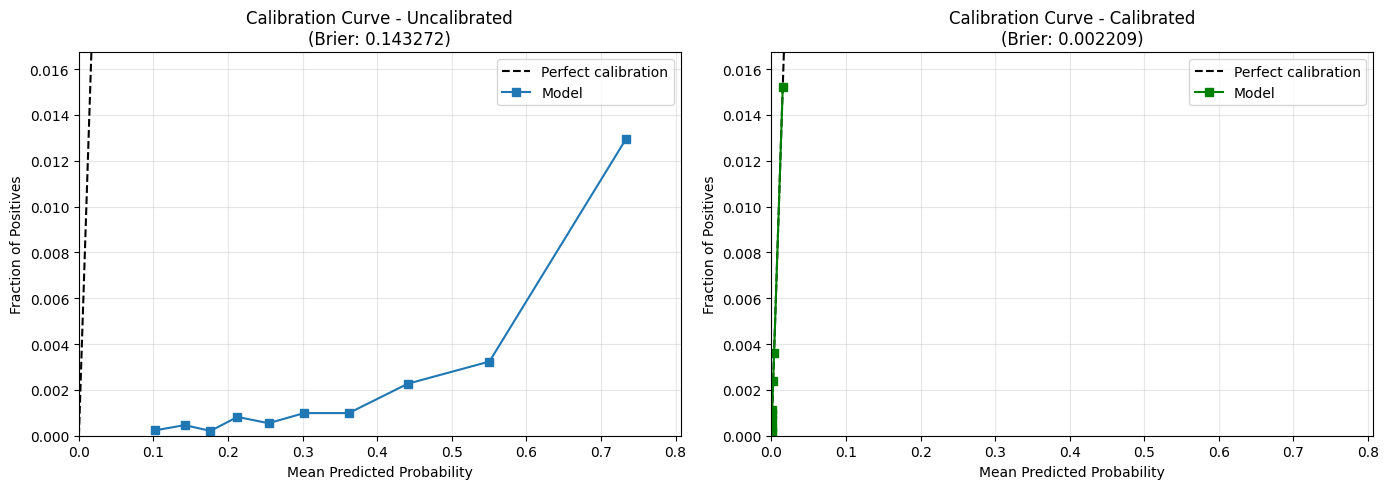


✓ Calibrator saved

⚠️ NOTE: Test set calibration uses validation-fitted calibrator
   This is correct methodology (no data leakage) but be aware that
   calibrator was not fit on test data itself


In [0]:
print("="*70)
print("MODEL PERFORMANCE")
print("="*70)

iteration_metrics = {}

# Get predictions for all splits
y_pred_train = model.predict_proba(X_train)[:, 1]
y_pred_val = model.predict_proba(X_val)[:, 1]
y_pred_test = model.predict_proba(X_test)[:, 1]

# Calculate performance metrics
for name, X, y, y_pred in [('Train', X_train, y_train, y_pred_train), 
                            ('Val', X_val, y_val, y_pred_val), 
                            ('Test', X_test, y_test, y_pred_test)]:
    
    print(name)
    
    auprc = average_precision_score(y, y_pred)
    auroc = roc_auc_score(y, y_pred)
    brier = brier_score_loss(y, y_pred)
    baseline_rate = y.mean()
    auprc_lift = auprc / baseline_rate if baseline_rate > 0 else 0
    
    iteration_metrics[name] = {
        'auprc': auprc,
        'auroc': auroc,
        'brier': brier,
        'baseline_rate': baseline_rate,
        'auprc_lift': auprc_lift,
        'n_obs': len(y),
        'n_events': int(y.sum())
    }
    
    print(f"\n{name}:")
    print(f"  Observations: {len(y):,}")
    print(f"  Events: {int(y.sum()):,}")
    print(f"  Baseline rate: {baseline_rate:.4%}")
    print(f"  AUPRC: {auprc:.4f} ({auprc_lift:.1f}x lift)")
    print(f"  AUROC: {auroc:.4f}")
    print(f"  Brier Score: {brier:.4f}")

print("\n" + "="*70)
print("PERFORMANCE SUMMARY:")
print(f"  Train AUPRC: {iteration_metrics['Train']['auprc']:.4f}")
print(f"  Val AUPRC:   {iteration_metrics['Val']['auprc']:.4f}")
print(f"  Test AUPRC:  {iteration_metrics['Test']['auprc']:.4f}")
print("="*70)

# COMMAND ----------

# ============================================================================
# CALIBRATION ANALYSIS
# ============================================================================
print("\n" + "="*70)
print("CALIBRATION ANALYSIS")
print("="*70)

# Fit isotonic regression on validation predictions
print("Fitting calibration model on validation predictions...")
iso_calibrator = IsotonicRegression(out_of_bounds='clip')
iso_calibrator.fit(y_pred_val, y_val)

# Apply calibration
y_pred_val_calibrated = iso_calibrator.predict(y_pred_val)
y_pred_test_calibrated = iso_calibrator.predict(y_pred_test)

# Calculate Brier scores
brier_uncalibrated_val = brier_score_loss(y_val, y_pred_val)
brier_calibrated_val = brier_score_loss(y_val, y_pred_val_calibrated)
brier_uncalibrated_test = brier_score_loss(y_test, y_pred_test)
brier_calibrated_test = brier_score_loss(y_test, y_pred_test_calibrated)

print(f"\nBrier Scores (lower is better):")
print(f"  Validation uncalibrated: {brier_uncalibrated_val:.6f}")
print(f"  Validation calibrated:   {brier_calibrated_val:.6f} ({((brier_calibrated_val - brier_uncalibrated_val)/brier_uncalibrated_val)*100:+.1f}%)")
print(f"  Test uncalibrated:       {brier_uncalibrated_test:.6f}")
print(f"  Test calibrated:         {brier_calibrated_test:.6f} ({((brier_calibrated_test - brier_uncalibrated_test)/brier_uncalibrated_test)*100:+.1f}%)")

# Plot calibration curves
n_bins = 10
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_val, y_pred_val, n_bins=n_bins, strategy='quantile'
)

fraction_of_positives_cal, mean_predicted_value_cal = calibration_curve(
    y_val, y_pred_val_calibrated, n_bins=n_bins, strategy='quantile'
)

# Determine axis limits based on actual data range
x_max = max(mean_predicted_value.max(), mean_predicted_value_cal.max()) * 1.1
y_max = max(fraction_of_positives.max(), fraction_of_positives_cal.max()) * 1.1

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Uncalibrated
axes[0].plot([0, x_max], [0, x_max], 'k--', label='Perfect calibration')
axes[0].plot(mean_predicted_value, fraction_of_positives, 's-', label='Model', markersize=6)
axes[0].set_xlim([0, x_max])
axes[0].set_ylim([0, y_max])
axes[0].set_xlabel('Mean Predicted Probability')
axes[0].set_ylabel('Fraction of Positives')
axes[0].set_title(f'Calibration Curve - Uncalibrated\n(Brier: {brier_uncalibrated_val:.6f})')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Calibrated
axes[1].plot([0, x_max], [0, x_max], 'k--', label='Perfect calibration')
axes[1].plot(mean_predicted_value_cal, fraction_of_positives_cal, 's-', label='Model', color='green', markersize=6)
axes[1].set_xlim([0, x_max])
axes[1].set_ylim([0, y_max])
axes[1].set_xlabel('Mean Predicted Probability')
axes[1].set_ylabel('Fraction of Positives')
axes[1].set_title(f'Calibration Curve - Calibrated\n(Brier: {brier_calibrated_val:.6f})')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Save calibrator
with open(f'iteration_isotonic_calibrators/calibrator_iteration_{ITERATION_NUMBER}.pkl', 'wb') as f:
    pickle.dump(iso_calibrator, f)

print(f"\n✓ Calibrator saved")

print("\n⚠️ NOTE: Test set calibration uses validation-fitted calibrator")
print("   This is correct methodology (no data leakage) but be aware that")
print("   calibrator was not fit on test data itself")
print("="*70)

## Step 7: Save Metrics to Tracking CSV

In [0]:
print("="*70)
print("SAVING METRICS TO TRACKING CSV")
print("="*70)

metrics_csv_path = 'iteration_metrics_tracker.csv'

# Calculate train calibrated predictions (need to add this before the metrics dict)
y_pred_train_calibrated = iso_calibrator.predict(y_pred_train)
brier_uncalibrated_train = brier_score_loss(y_train, y_pred_train)
brier_calibrated_train = brier_score_loss(y_train, y_pred_train_calibrated)

# Prepare current iteration metrics
current_metrics = {
    'iteration': ITERATION_NUMBER,
    'timestamp': datetime.now().isoformat(),
    'n_features': len(feature_cols),
    'features_removed': len(FEATURES_REMOVED_THIS_ROUND),
    
    # Training metrics
    'train_auprc': iteration_metrics['Train']['auprc'],
    'train_auroc': iteration_metrics['Train']['auroc'],
    'train_brier': iteration_metrics['Train']['brier'],
    'train_baseline_rate': iteration_metrics['Train']['baseline_rate'],
    'train_n_events': iteration_metrics['Train']['n_events'],
    
    # Validation metrics
    'val_auprc': iteration_metrics['Val']['auprc'],
    'val_auroc': iteration_metrics['Val']['auroc'],
    'val_brier': iteration_metrics['Val']['brier'],
    'val_baseline_rate': iteration_metrics['Val']['baseline_rate'],
    'val_n_events': iteration_metrics['Val']['n_events'],
    
    # Test metrics
    'test_auprc': iteration_metrics['Test']['auprc'],
    'test_auroc': iteration_metrics['Test']['auroc'],
    'test_brier': iteration_metrics['Test']['brier'],
    'test_baseline_rate': iteration_metrics['Test']['baseline_rate'],
    'test_n_events': iteration_metrics['Test']['n_events'],
    
    # Calibration metrics
    'train_brier_uncalibrated': brier_uncalibrated_train,
    'train_brier_calibrated': brier_calibrated_train,
    'val_brier_uncalibrated': brier_uncalibrated_val,
    'val_brier_calibrated': brier_calibrated_val,
    'test_brier_uncalibrated': brier_uncalibrated_test,
    'test_brier_calibrated': brier_calibrated_test,
    
    # Overfitting indicators
    'train_val_auprc_gap': iteration_metrics['Train']['auprc'] - iteration_metrics['Val']['auprc'],
    'train_val_auroc_gap': iteration_metrics['Train']['auroc'] - iteration_metrics['Val']['auroc'],
    
    # Model info
    'best_iteration': int(model.best_iteration),
    'best_score': float(model.best_score),
    'scale_pos_weight': float(scale_pos_weight)
}

# Append or create CSV
if os.path.exists(metrics_csv_path):
    existing_df = pd.read_csv(metrics_csv_path)
    
    # Check if this iteration already exists
    if ITERATION_NUMBER in existing_df['iteration'].values:
        print(f"⚠ Iteration {ITERATION_NUMBER} already exists - overwriting")
        existing_df = existing_df[existing_df['iteration'] != ITERATION_NUMBER]
    
    metrics_df = pd.concat([existing_df, pd.DataFrame([current_metrics])], ignore_index=True)
    metrics_df = metrics_df.sort_values('iteration').reset_index(drop=True)
    print(f"✓ Appended iteration {ITERATION_NUMBER} to existing tracker")
else:
    metrics_df = pd.DataFrame([current_metrics])
    print(f"✓ Created new tracker with iteration {ITERATION_NUMBER}")

metrics_df.to_csv(metrics_csv_path, index=False)

print(f"\n📊 Metrics saved to: {metrics_csv_path}")
print(f"   Total iterations tracked: {len(metrics_df)}")

# Display tracker
print("\n" + "="*70)
print("ITERATION PERFORMANCE TRACKER")
print("="*70)

display_cols = [
    'iteration', 'n_features', 'features_removed',
    'train_auprc', 'val_auprc', 'test_auprc',
    'train_val_auprc_gap',
    'train_brier_calibrated', 'val_brier_calibrated', 'test_brier_calibrated'
]

print("\nPerformance progression:")
print(metrics_df[display_cols].to_string(index=False))

# Calculate deltas if multiple iterations exist
if len(metrics_df) > 1:
    baseline_train_auprc = metrics_df.iloc[0]['train_auprc']
    baseline_val_auprc = metrics_df.iloc[0]['val_auprc']
    baseline_test_auprc = metrics_df.iloc[0]['test_auprc']
    current_train_auprc = metrics_df.iloc[-1]['train_auprc']
    current_val_auprc = metrics_df.iloc[-1]['val_auprc']
    current_test_auprc = metrics_df.iloc[-1]['test_auprc']
    
    print(f"\n📈 Performance vs Initial:")
    print(f"   Train AUPRC: {current_train_auprc:.4f} (Δ {current_train_auprc - baseline_train_auprc:+.4f})")
    print(f"   Val AUPRC:   {current_val_auprc:.4f} (Δ {current_val_auprc - baseline_val_auprc:+.4f})")
    print(f"   Test AUPRC:  {current_test_auprc:.4f} (Δ {current_test_auprc - baseline_test_auprc:+.4f})")
    
    # Overfitting check
    current_gap = metrics_df.iloc[-1]['train_val_auprc_gap']
    baseline_gap = metrics_df.iloc[0]['train_val_auprc_gap']
    print(f"\n🔍 Overfitting Indicator (Train-Val AUPRC Gap):")
    print(f"   Current: {current_gap:.4f}")
    print(f"   Initial: {baseline_gap:.4f}")
    print(f"   Change:  {current_gap - baseline_gap:+.4f}")
    if current_gap > baseline_gap + 0.005:
        print(f"   ⚠️  Warning: Gap increasing (potential overfitting)")
    elif current_gap < baseline_gap - 0.005:
        print(f"   ✓ Gap decreasing (improved generalization)")
    else:
        print(f"   ✓ Gap stable")

print("="*70)

SAVING METRICS TO TRACKING CSV
✓ Created new tracker with iteration 1

📊 Metrics saved to: iteration_metrics_tracker.csv
   Total iterations tracked: 1

ITERATION PERFORMANCE TRACKER

Performance progression:
 iteration  n_features  features_removed  train_auprc  val_auprc  test_auprc  train_val_auprc_gap  train_brier_calibrated  val_brier_calibrated  test_brier_calibrated
         1         168                 0     0.061168   0.042229    0.045414              0.01894                0.002252              0.002209               0.002279


## Step 8: Visualize Performance Trends (if multiple iterations)

In [0]:
if os.path.exists('iteration_metrics_tracker.csv'):
    tracker_df = pd.read_csv('iteration_metrics_tracker.csv')
    
    if len(tracker_df) > 1:
        print("="*70)
        print("PERFORMANCE TRENDS ACROSS ITERATIONS")
        print("="*70)
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # AUPRC trends
        axes[0, 0].plot(tracker_df['iteration'], tracker_df['train_auprc'], 
                       marker='o', label='Train', linewidth=2, alpha=0.7)
        axes[0, 0].plot(tracker_df['iteration'], tracker_df['val_auprc'], 
                       marker='s', label='Validation', linewidth=2)
        axes[0, 0].plot(tracker_df['iteration'], tracker_df['test_auprc'], 
                       marker='^', label='Test', linewidth=2)
        axes[0, 0].set_xlabel('Iteration')
        axes[0, 0].set_ylabel('AUPRC')
        axes[0, 0].set_title('AUPRC Across Iterations')
        axes[0, 0].legend()
        axes[0, 0].grid(alpha=0.3)
        
        # AUROC trends
        axes[0, 1].plot(tracker_df['iteration'], tracker_df['train_auroc'], 
                       marker='o', label='Train', linewidth=2, alpha=0.7)
        axes[0, 1].plot(tracker_df['iteration'], tracker_df['val_auroc'], 
                       marker='s', label='Validation', linewidth=2)
        axes[0, 1].plot(tracker_df['iteration'], tracker_df['test_auroc'], 
                       marker='^', label='Test', linewidth=2)
        axes[0, 1].set_xlabel('Iteration')
        axes[0, 1].set_ylabel('AUROC')
        axes[0, 1].set_title('AUROC Across Iterations')
        axes[0, 1].legend()
        axes[0, 1].grid(alpha=0.3)
        
        # Brier score
        axes[1, 0].plot(tracker_df['iteration'], tracker_df['val_brier_calibrated'], 
                       marker='s', label='Validation', linewidth=2)
        axes[1, 0].plot(tracker_df['iteration'], tracker_df['test_brier_calibrated'], 
                       marker='^', label='Test', linewidth=2)
        axes[1, 0].set_xlabel('Iteration')
        axes[1, 0].set_ylabel('Brier Score (calibrated)')
        axes[1, 0].set_title('Calibration Quality (lower = better)')
        axes[1, 0].legend()
        axes[1, 0].grid(alpha=0.3)
        
        # Feature count
        axes[1, 1].plot(tracker_df['iteration'], tracker_df['n_features'], 
                       marker='o', linewidth=2, color='green')
        axes[1, 1].set_xlabel('Iteration')
        axes[1, 1].set_ylabel('Number of Features')
        axes[1, 1].set_title('Feature Reduction Progress')
        axes[1, 1].grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print("\n✓ Performance trends visualized")
    else:
        print("Only 1 iteration tracked - skipping trend visualization")

Only 1 iteration tracked - skipping trend visualization


## Step 9: Compute SHAP Values

In [0]:
print("="*70)
print("COMPUTING SHAP VALUES - FULL VALIDATION SET")
print("="*70)

# Use ALL validation data, compute separately for positive/negative
pos_indices = y_val[y_val == 1].index
neg_indices = y_val[y_val == 0].index

n_pos = len(pos_indices)
n_neg = len(neg_indices)

print(f"SHAP computation on full validation set:")
print(f"  Positive cases: {n_pos:,}")
print(f"  Negative cases: {n_neg:,}")
print(f"  Total: {len(y_val):,}")
print(f"  Class ratio: 1:{n_neg/n_pos:.1f}")

explainer = shap.TreeExplainer(model)

print(f"\nComputing SHAP for positive cases...")
import time
start = time.time()
shap_values_pos = explainer.shap_values(X_val.loc[pos_indices])
pos_time = time.time() - start
print(f"  Completed in {pos_time:.1f} seconds")

print(f"\nComputing SHAP for negative cases...")
start = time.time()
shap_values_neg = explainer.shap_values(X_val.loc[neg_indices])
neg_time = time.time() - start
print(f"  Completed in {neg_time:.1f} seconds")

# Calculate importance metrics
importance_pos = np.abs(shap_values_pos).mean(axis=0)
importance_neg = np.abs(shap_values_neg).mean(axis=0)
importance_ratio = importance_pos / (importance_neg + 1e-10)

# Weight positive cases 2:1 to emphasize rare event detection
# This is intentional for 0.2% prevalence - we prioritize identifying true positives
importance_combined = (importance_pos * 2 + importance_neg) / 3

print(f"\n✓ SHAP computation complete")
print(f"  Total time: {pos_time + neg_time:.1f} seconds")
print("="*70)

COMPUTING SHAP VALUES - FULL VALIDATION SET
SHAP computation on full validation set:
  Positive cases: 1,080
  Negative cases: 474,548
  Total: 475,628
  Class ratio: 1:439.4


[01:07:45] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.



Computing SHAP for positive cases...
  Completed in 2.9 seconds

Computing SHAP for negative cases...
  Completed in 1201.2 seconds

✓ SHAP computation complete
  Total time: 1204.0 seconds


## Step 10: Feature Importance Analysis

In [0]:
# Create importance DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'SHAP_Positive': importance_pos,
    'SHAP_Negative': importance_neg,
    'SHAP_Ratio': importance_ratio,
    'SHAP_Combined': importance_combined
}).sort_values('SHAP_Combined', ascending=False)

importance_df['Rank'] = range(1, len(importance_df) + 1)
importance_df['Pct_Total'] = (importance_df['SHAP_Combined'] / 
                               importance_df['SHAP_Combined'].sum() * 100)
importance_df['Cumulative_Pct'] = importance_df['Pct_Total'].cumsum()

print("="*70)
print("FEATURE IMPORTANCE RANKINGS")
print("="*70)

print(f"\nAll {len(importance_df)} features (sorted by SHAP_Combined):")
print(importance_df[['Rank', 'Feature', 'SHAP_Combined', 'SHAP_Ratio', 'Pct_Total', 'Cumulative_Pct']].to_string(index=False))

print("\n" + "="*70)
print("IMPORTANCE DISTRIBUTION SUMMARY")
print("="*70)
print(f"Total importance: {importance_df['SHAP_Combined'].sum():.4f}")
print(f"\nCumulative importance by feature count:")
print(f"  Top 10 features: {importance_df.head(10)['Pct_Total'].sum():.1f}%")
print(f"  Top 30 features: {importance_df.head(30)['Pct_Total'].sum():.1f}%")
print(f"  Top 50 features: {importance_df.head(50)['Pct_Total'].sum():.1f}%")
print(f"\nFeature quality metrics:")
print(f"  Features with SHAP_Ratio > 2.0: {(importance_df['SHAP_Ratio'] > 2.0).sum()}")
print(f"  Features with SHAP_Ratio < 0.3: {(importance_df['SHAP_Ratio'] < 0.3).sum()}")
print(f"  Features with near-zero importance (<0.0001): {(importance_df['SHAP_Combined'] < 0.0001).sum()}")
print("="*70)

FEATURE IMPORTANCE RANKINGS

All 168 features (sorted by SHAP_Combined):
 Rank                              Feature  SHAP_Combined  SHAP_Ratio  Pct_Total  Cumulative_Pct
    1                 V_SBP_VARIABILITY_6M       0.231074    1.133496   8.452420        8.452420
    2         VISIT_OUTPATIENT_VISITS_12MO       0.176846    1.362292   6.468809       14.921228
    3            V_MAX_WEIGHT_LOSS_PCT_60D       0.172467    1.359204   6.308647       21.229876
    4                            AGE_GROUP       0.171899    0.654397   6.287854       27.517731
    5                ICD_HIGH_RISK_HISTORY       0.170600    1.244234   6.240358       33.758087
    6            V_WEIGHT_TRAJECTORY_SLOPE       0.115322    0.806373   4.218351       37.976440
    7      VISIT_GI_SYMPTOM_OP_VISITS_12MO       0.112797    2.006067   4.125963       42.102402
    8                    LAB_ALBUMIN_VALUE       0.092825    0.929702   3.395412       45.497814
    9                  LAB_PLATELETS_VALUE       0.083

## Step 10b: Validate No Patient Memorization


In [0]:
print("="*70)
print("PATIENT MEMORIZATION CHECK")
print("="*70)

def check_patient_memorization(df, X, y, model):
    """
    Check if model memorizes patient patterns by comparing:
    1. Performance on patients with multiple observations
    2. Within-patient prediction consistency
    """
    
    # Find patients with multiple observations
    patient_obs_counts = df.groupby('PAT_ID').size()
    multi_obs_patients = patient_obs_counts[patient_obs_counts > 1]
    
    print(f"\nPatient observation distribution:")
    print(f"  Patients with 1 observation: {(patient_obs_counts == 1).sum():,}")
    print(f"  Patients with 2+ observations: {len(multi_obs_patients):,}")
    print(f"  Max observations per patient: {patient_obs_counts.max()}")
    
    # Calculate patient-level metrics
    df_with_preds = df.copy()
    df_with_preds['predicted_prob'] = model.predict_proba(X)[:, 1]
    
    # Aggregate to patient level
    patient_level = df_with_preds.groupby('PAT_ID').agg({
        'FUTURE_CRC_EVENT': 'max',  # Patient has event if any observation has event
        'predicted_prob': 'mean'     # Average prediction across patient's observations
    })
    
    # Compare observation-level vs patient-level performance
    obs_auprc = average_precision_score(y, df_with_preds['predicted_prob'])
    pat_auprc = average_precision_score(patient_level['FUTURE_CRC_EVENT'], 
                                        patient_level['predicted_prob'])
    
    print(f"\nPerformance comparison:")
    print(f"  Observation-level AUPRC: {obs_auprc:.4f}")
    print(f"  Patient-level AUPRC: {pat_auprc:.4f}")
    print(f"  Ratio (obs/patient): {obs_auprc/pat_auprc:.2f}")
    
    if obs_auprc/pat_auprc > 1.5:
        print("  ⚠️ WARNING: Large performance gap suggests possible memorization")
    else:
        print("  ✓ Performance gap is acceptable")
    
    # Check prediction variance within patients
    multi_obs_subset = df_with_preds[df_with_preds['PAT_ID'].isin(multi_obs_patients.index)]
    within_patient_std = multi_obs_subset.groupby('PAT_ID')['predicted_prob'].std()
    
    print(f"\nWithin-patient prediction consistency:")
    print(f"  Mean std dev of predictions: {within_patient_std.mean():.4f}")
    print(f"  Max std dev of predictions: {within_patient_std.max():.4f}")
    
    if within_patient_std.mean() < 0.01:
        print("  ⚠️ WARNING: Very low variance suggests model memorizes patients")
    else:
        print("  ✓ Reasonable prediction variance within patients")
    
    return {
        'obs_auprc': obs_auprc,
        'pat_auprc': pat_auprc,
        'memorization_ratio': obs_auprc/pat_auprc,
        'within_patient_std': within_patient_std.mean()
    }

# Run memorization check on test set
print("\nChecking test set for memorization patterns...")
memorization_metrics = check_patient_memorization(test_df, X_test, y_test, model)

# Store in tracking
iteration_metrics['memorization_ratio'] = memorization_metrics['memorization_ratio']
iteration_metrics['within_patient_std'] = memorization_metrics['within_patient_std']

print("="*70)

PATIENT MEMORIZATION CHECK

Checking test set for memorization patterns...

Patient observation distribution:
  Patients with 1 observation: 5,147
  Patients with 2+ observations: 52,046
  Max observations per patient: 24

Performance comparison:
  Observation-level AUPRC: 0.0454
  Patient-level AUPRC: 0.0341
  Ratio (obs/patient): 1.33
  ✓ Performance gap is acceptable

Within-patient prediction consistency:
  Mean std dev of predictions: 0.0697
  Max std dev of predictions: 0.4015
  ✓ Reasonable prediction variance within patients


## Step 11: Conservative Feature Selection for Iteration 1

For the first iteration, we remove only the lowest-value features that meet
multiple removal criteria. Target: ~15-18% reduction (25-30 features).

In [0]:
print("="*70)
print("CONSERVATIVE FEATURE REMOVAL ANALYSIS - ITERATION 1 (INITIAL)")
print("="*70)

# Load clustering information
cluster_df = pd.read_csv('all_clusters_threshold_0.7.csv')
cluster_importance = cluster_df.merge(importance_df, on='Feature', how='left')

# ============================================================================
# CONSERVATIVE CRITERIA FOR FIRST ITERATION
# ============================================================================
# Target: Remove ~15% of features (25-30 features) in first pass

# Adjusted thresholds for first iteration (slightly less strict)
zero_threshold = 0.0002  # Was 0.0001 - still very conservative
ratio_threshold = 0.15    # Was 0.1 - captures more negative-biased features
bottom_percentile = 8     # Was 5 - expands to bottom 8%

print(f"\nRemoval criteria (INITIAL CONSERVATIVE PASS):")
print(f"  Near-zero importance threshold: < {zero_threshold}")
print(f"  Negative-bias ratio threshold: < {ratio_threshold}")
print(f"  Bottom percentile: {bottom_percentile}%")

# Calculate features meeting each criterion
zero_importance_features = set(importance_df[importance_df['SHAP_Combined'] < zero_threshold]['Feature'])
neg_biased_features = set(importance_df[importance_df['SHAP_Ratio'] < ratio_threshold]['Feature'])
importance_percentile = importance_df['SHAP_Combined'].quantile(bottom_percentile/100)
bottom_features = set(importance_df[importance_df['SHAP_Combined'] < importance_percentile]['Feature'])

# For iteration 1: Feature must meet AT LEAST 2 of 3 criteria
features_meeting_two_criteria = (
    (zero_importance_features & neg_biased_features) |
    (zero_importance_features & bottom_features) |
    (neg_biased_features & bottom_features)
)

# Also include features meeting all three (they're definitely removable)
features_meeting_all = zero_importance_features & neg_biased_features & bottom_features

features_flagged = features_meeting_two_criteria

print(f"\nFeatures identified:")
print(f"  Near-zero importance: {len(zero_importance_features)}")
print(f"  Strongly negative-biased: {len(neg_biased_features)}")
print(f"  Bottom {bottom_percentile}%: {len(bottom_features)}")
print(f"  Meeting ALL criteria: {len(features_meeting_all)}")
print(f"  Meeting 2+ criteria: {len(features_flagged)}")

# ============================================================================
# GLOBAL REMOVAL CAP FOR ITERATION 1
# ============================================================================
MAX_REMOVALS_ITERATION_1 = 30  # Hard cap at ~18% of features (was 25)
MIN_FEATURES_TO_RETAIN = 120   # Never go below this

print(f"\nGlobal constraints:")
print(f"  Maximum removals allowed: {MAX_REMOVALS_ITERATION_1}")
print(f"  Minimum features to retain: {MIN_FEATURES_TO_RETAIN}")
print(f"  Current feature count: {len(feature_cols)}")

# ============================================================================
# ANALYZE FLAGGED FEATURES BY CLUSTER
# ============================================================================
cluster_removal_candidates = {}

for cluster_id in cluster_importance['Cluster'].unique():
    cluster_features = cluster_importance[cluster_importance['Cluster'] == cluster_id]
    cluster_size = len(cluster_features)
    
    # Find flagged features in this cluster
    flagged_in_cluster = list(set(cluster_features['Feature'].tolist()) & features_flagged)
    
    if not flagged_in_cluster:
        continue
    
    # Get SHAP scores for flagged features
    flagged_with_scores = []
    for feat in flagged_in_cluster:
        shap = importance_df[importance_df['Feature'] == feat]['SHAP_Combined'].values[0]
        ratio = importance_df[importance_df['Feature'] == feat]['SHAP_Ratio'].values[0]
        meets_all = feat in features_meeting_all
        flagged_with_scores.append((feat, shap, ratio, meets_all))
    
    # Sort by: (1) meets all criteria, then (2) SHAP score ascending
    flagged_with_scores.sort(key=lambda x: (not x[3], x[1]))
    
    cluster_removal_candidates[cluster_id] = {
        'size': cluster_size,
        'flagged': flagged_with_scores,
        'max_shap': cluster_features['SHAP_Combined'].max()
    }

# ============================================================================
# CONSERVATIVE CLUSTER REMOVAL RULES
# ============================================================================
print(f"\n" + "-"*70)
print("APPLYING CONSERVATIVE CLUSTER REMOVAL RULES")
print("-"*70)

removals_by_priority = []

for cluster_id, cluster_info in cluster_removal_candidates.items():
    cluster_size = cluster_info['size']
    flagged_list = cluster_info['flagged']
    max_shap = cluster_info['max_shap']
    
    # Slightly less conservative limits for first iteration (adjusted to reach target)
    if cluster_size == 1:
        # Singleton - can remove if flagged (relaxed from requiring all criteria)
        max_remove = 1
    elif cluster_size <= 3:
        # Small cluster - MAX 2 removals, must leave at least 1
        max_remove = min(2, cluster_size - 1)  # Was max 1
    elif cluster_size <= 7:
        # Medium cluster - MAX 2 removals, must leave at least 3
        max_remove = min(2, cluster_size - 3) if cluster_size > 3 else 0  # Was max 1
    else:
        # Large cluster - MAX 3 removals, must leave at least 5
        max_remove = min(3, cluster_size - 5) if cluster_size > 5 else 0  # Was max 2
    
    # Additional protection for important clusters
    if max_shap > importance_df['SHAP_Combined'].quantile(0.80):
        max_remove = min(max_remove, 1)  # High-importance clusters: max 1 removal
    
    # Select worst features up to limit
    for i, (feat, shap, ratio, meets_all) in enumerate(flagged_list[:max_remove]):
        priority_score = shap * 1000 + (0 if meets_all else 1)  # Prioritize features meeting all criteria
        removals_by_priority.append((feat, shap, ratio, cluster_id, cluster_size, priority_score))

# Sort by priority score and apply global limit
removals_by_priority.sort(key=lambda x: x[5])  # Sort by priority score
final_removals = removals_by_priority[:MAX_REMOVALS_ITERATION_1]

safe_to_remove = [feat for feat, _, _, _, _, _ in final_removals]
deferred_to_later = [feat for feat, _, _, _, _, _ in removals_by_priority[MAX_REMOVALS_ITERATION_1:]]

# Also add HAS_PCP_AT_END if present (already filtered in WHERE clause)
if 'HAS_PCP_AT_END' in feature_cols and 'HAS_PCP_AT_END' not in safe_to_remove:
    safe_to_remove.append('HAS_PCP_AT_END')
    print("\nNote: Added HAS_PCP_AT_END (already filtered in data)")

# ============================================================================
# REMOVAL BREAKDOWN
# ============================================================================
print(f"\nRemoval summary by cluster size:")
print("-" * 60)

cluster_type_removals = {'SINGLETON': 0, 'SMALL': 0, 'MEDIUM': 0, 'LARGE': 0}
for feat, shap, ratio, cluster_id, cluster_size, _ in final_removals:
    if cluster_size == 1:
        cluster_type_removals['SINGLETON'] += 1
    elif cluster_size <= 3:
        cluster_type_removals['SMALL'] += 1
    elif cluster_size <= 7:
        cluster_type_removals['MEDIUM'] += 1
    else:
        cluster_type_removals['LARGE'] += 1

print(f"  Singletons: {cluster_type_removals['SINGLETON']}")
print(f"  Small (2-3): {cluster_type_removals['SMALL']}")
print(f"  Medium (4-7): {cluster_type_removals['MEDIUM']}")
print(f"  Large (8+): {cluster_type_removals['LARGE']}")

# Show specific removals
print(f"\nFeatures selected for removal ({len(safe_to_remove)} total):")
print("-" * 60)
for feat, shap, ratio, cluster_id, cluster_size, _ in final_removals[:10]:  # Show first 10
    print(f"  {feat:<50} SHAP={shap:.6f}, Ratio={ratio:.3f}, Cluster={cluster_id} (size={cluster_size})")
if len(final_removals) > 10:
    print(f"  ... and {len(final_removals) - 10} more")

# ============================================================================
# SAFETY VALIDATION
# ============================================================================
remaining_after_removal = len(feature_cols) - len(safe_to_remove)

print(f"\n" + "="*70)
print("SAFETY VALIDATION")
print("="*70)
print(f"  Current features: {len(feature_cols)}")
print(f"  Removing: {len(safe_to_remove)} ({len(safe_to_remove)/len(feature_cols)*100:.1f}%)")
print(f"  Remaining: {remaining_after_removal}")
print(f"  Minimum threshold: {MIN_FEATURES_TO_RETAIN}")

if remaining_after_removal < MIN_FEATURES_TO_RETAIN:
    print(f"  ⚠️ WARNING: Would violate minimum threshold - adjusting removal list")
    max_allowed = len(feature_cols) - MIN_FEATURES_TO_RETAIN
    safe_to_remove = safe_to_remove[:max_allowed]
    print(f"  ✓ Adjusted to remove only {len(safe_to_remove)} features")

# ============================================================================
# SAVE OUTPUTS
# ============================================================================
removal_output_path = f'iteration_removal_candidates/iteration_{ITERATION_NUMBER}_removal_candidates.txt'
with open(removal_output_path, 'w') as f:
    f.write(f"# Iteration {ITERATION_NUMBER} - Conservative Initial Removal\n")
    f.write(f"# Generated: {datetime.now()}\n")
    f.write(f"# Strategy: Conservative first pass (~15% reduction)\n")
    f.write(f"# Criteria: Features must meet 2+ of: near-zero, negative-biased, bottom 8%\n")
    f.write(f"# Current features: {len(feature_cols)}\n")
    f.write(f"# Removing: {len(safe_to_remove)}\n")
    f.write(f"# Deferred: {len(deferred_to_later)}\n")
    f.write(f"# Remaining: {len(feature_cols) - len(safe_to_remove)}\n\n")
    f.write("# FEATURES TO REMOVE:\n")
    for feat in sorted(safe_to_remove):
        if feat in importance_df['Feature'].values:
            shap = importance_df[importance_df['Feature'] == feat]['SHAP_Combined'].values[0]
            ratio = importance_df[importance_df['Feature'] == feat]['SHAP_Ratio'].values[0]
            f.write(f"'{feat}',  # SHAP={shap:.6f}, Ratio={ratio:.3f}\n")
        else:
            f.write(f"'{feat}',\n")

deferred_output_path = f'iteration_deferred_features/iteration_{ITERATION_NUMBER}_deferred.txt'
with open(deferred_output_path, 'w') as f:
    f.write(f"# Iteration {ITERATION_NUMBER} - Deferred Features\n")
    f.write(f"# These {len(deferred_to_later)} features were flagged but not removed due to:\n")
    f.write(f"#  - Global cap of {MAX_REMOVALS_ITERATION_1} removals\n")
    f.write(f"#  - Cluster preservation rules\n\n")
    for feat in deferred_to_later:
        f.write(f"{feat}\n")

print(f"\n" + "="*70)
print("ITERATION 1 REMOVAL SUMMARY")
print("="*70)
print(f"✓ Removing {len(safe_to_remove)} features ({len(safe_to_remove)/len(feature_cols)*100:.1f}%)")
print(f"✓ Retaining {len(feature_cols) - len(safe_to_remove)} features")
print(f"✓ Deferred {len(deferred_to_later)} flagged features for future consideration")
print(f"\nOutputs saved:")
print(f"  - {removal_output_path}")
print(f"  - {deferred_output_path}")
print("="*70)

CONSERVATIVE FEATURE REMOVAL ANALYSIS - ITERATION 1 (INITIAL)

Removal criteria (INITIAL CONSERVATIVE PASS):
  Near-zero importance threshold: < 0.0002
  Negative-bias ratio threshold: < 0.15
  Bottom percentile: 8%

Features identified:
  Near-zero importance: 54
  Strongly negative-biased: 22
  Bottom 8%: 0
  Meeting ALL criteria: 0
  Meeting 2+ criteria: 22

Global constraints:
  Maximum removals allowed: 30
  Minimum features to retain: 120
  Current feature count: 168

----------------------------------------------------------------------
APPLYING CONSERVATIVE CLUSTER REMOVAL RULES
----------------------------------------------------------------------

Removal summary by cluster size:
------------------------------------------------------------
  Singletons: 10
  Small (2-3): 7
  Medium (4-7): 4
  Large (8+): 0

Features selected for removal (21 total):
------------------------------------------------------------
  ICD_FHX_FIRST_DEGREE_CRC                           SHAP=0.000000, 

## Step 12: Visualize Feature Importance


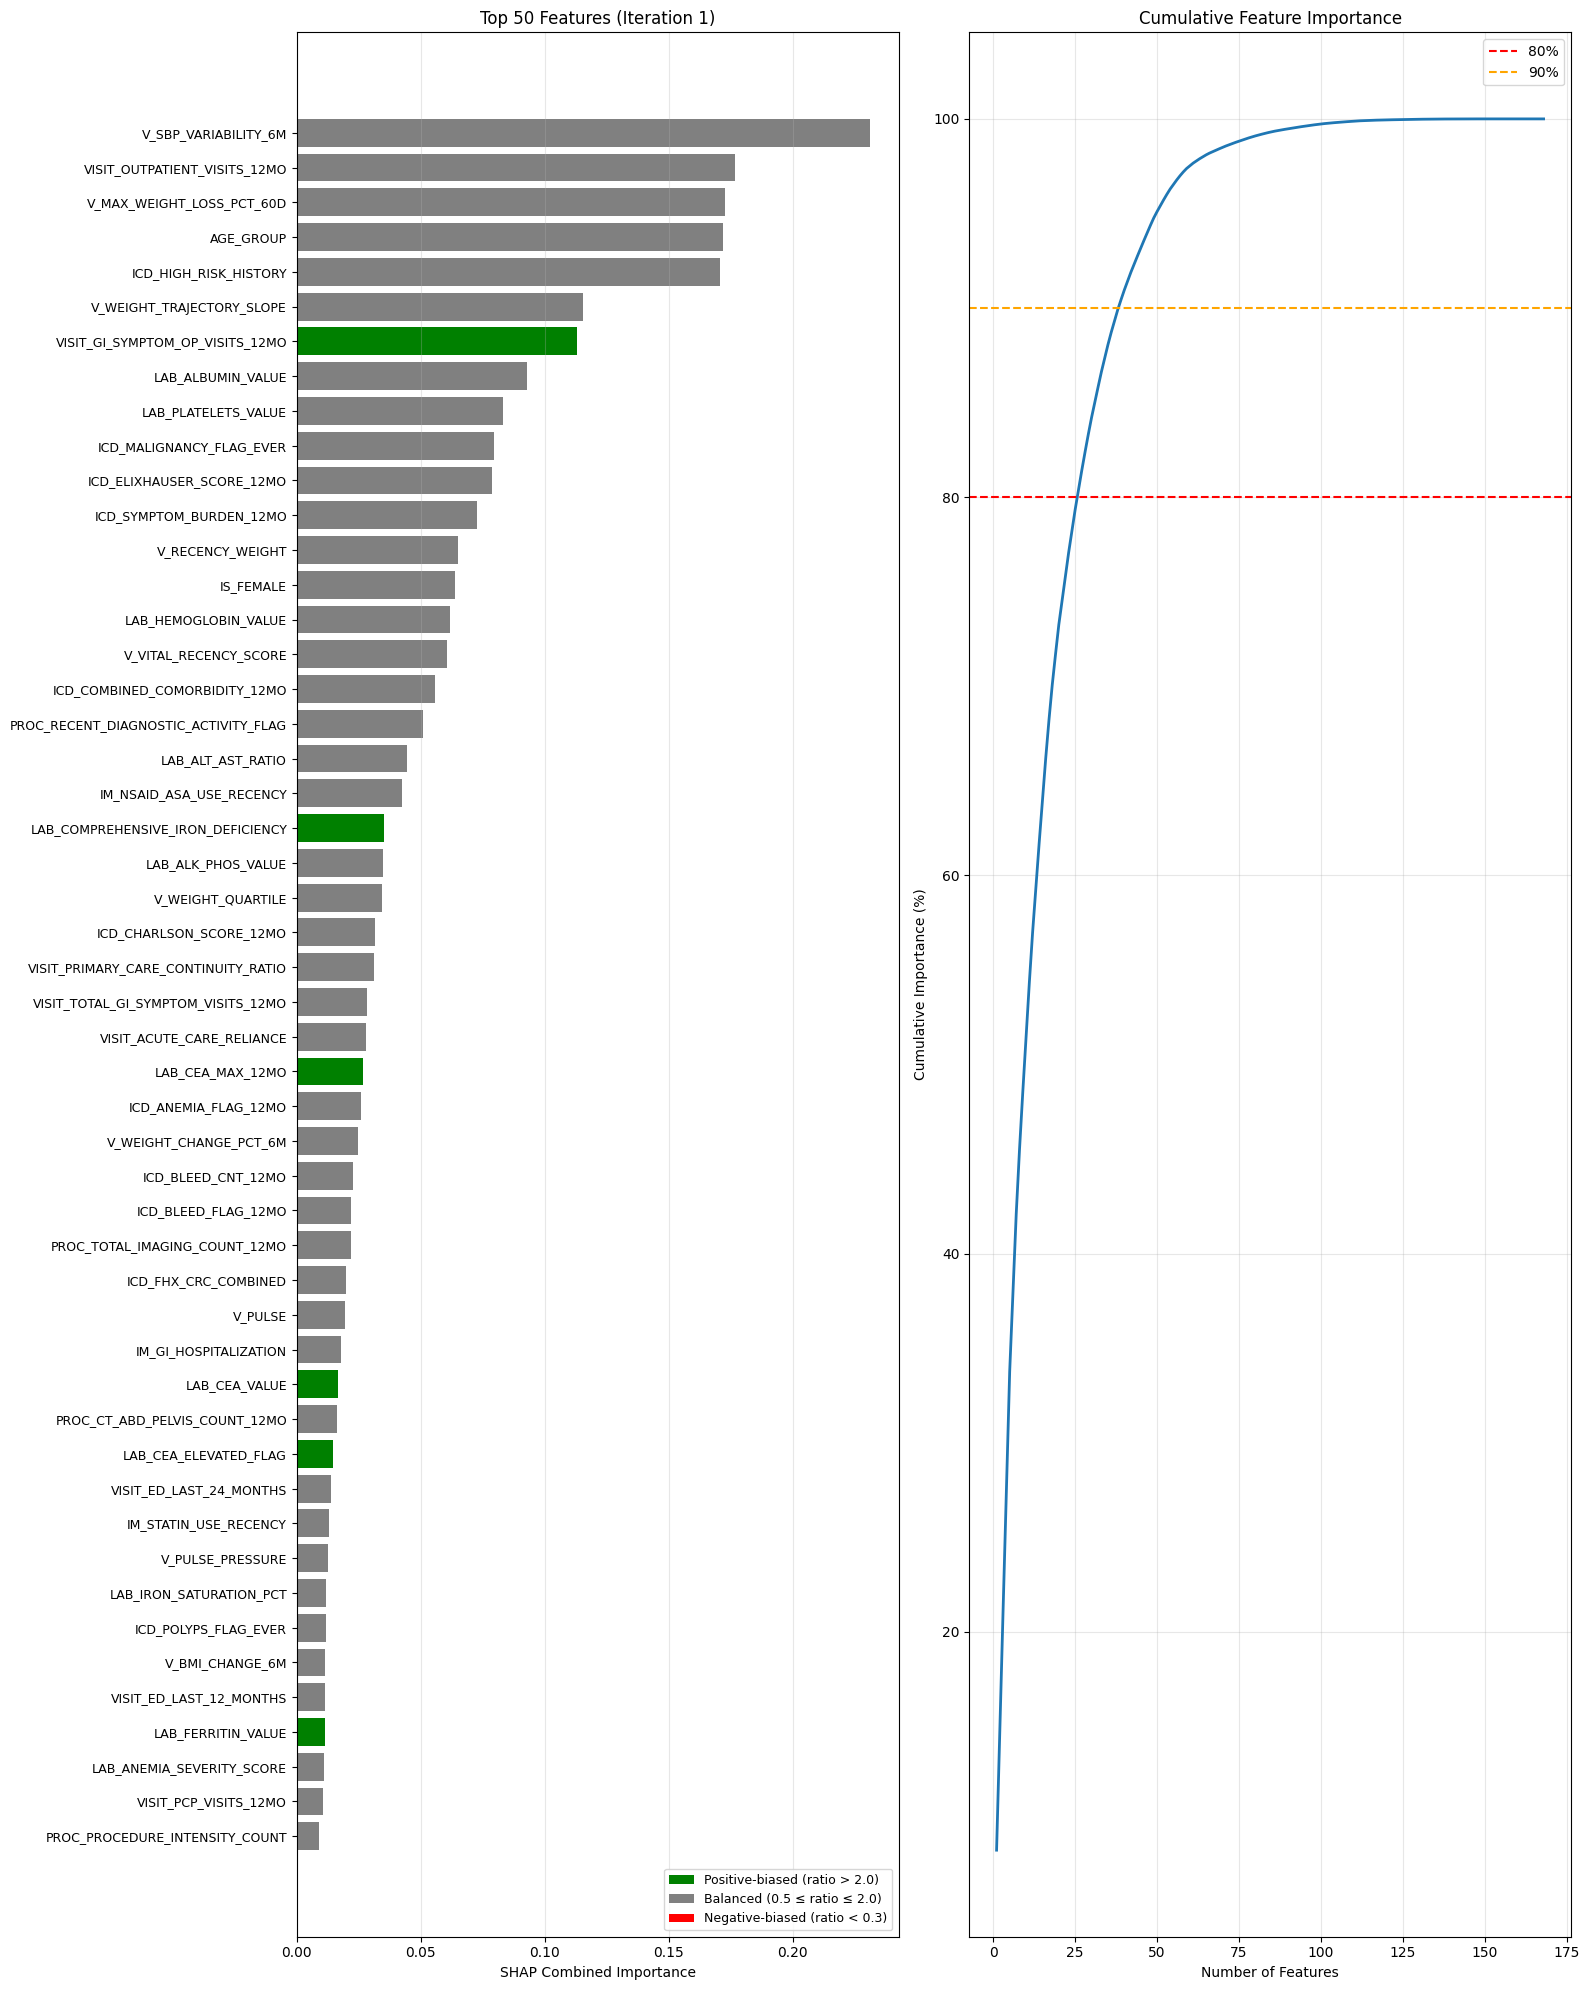

In [0]:
fig, axes = plt.subplots(1, 2, figsize=(16, 20))

# Top 50 features
top_50 = importance_df.head(50)
colors = ['green' if r > 2.0 else 'red' if r < 0.5 else 'gray' for r in top_50['SHAP_Ratio']]
axes[0].barh(range(len(top_50)), top_50['SHAP_Combined'], color=colors)
axes[0].set_yticks(range(len(top_50)))
axes[0].set_yticklabels(top_50['Feature'], fontsize=9)
axes[0].invert_yaxis()
axes[0].set_xlabel('SHAP Combined Importance', fontsize=10)
axes[0].set_title(f'Top 50 Features (Iteration {ITERATION_NUMBER})', fontsize=12)
axes[0].grid(axis='x', alpha=0.3)

# Add legend for colors
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', label='Positive-biased (ratio > 2.0)'),
    Patch(facecolor='gray', label='Balanced (0.5 ≤ ratio ≤ 2.0)'),
    Patch(facecolor='red', label='Negative-biased (ratio < 0.3)')
]
axes[0].legend(handles=legend_elements, loc='lower right', fontsize=9)

# Cumulative importance
axes[1].plot(range(1, len(importance_df)+1), 
             importance_df['Pct_Total'].cumsum(), linewidth=2)
axes[1].axhline(y=80, color='r', linestyle='--', label='80%')
axes[1].axhline(y=90, color='orange', linestyle='--', label='90%')
axes[1].set_xlabel('Number of Features', fontsize=10)
axes[1].set_ylabel('Cumulative Importance (%)', fontsize=10)
axes[1].set_title('Cumulative Feature Importance', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Next Steps
 
1. Review `iteration_X_removal_candidates.txt`
2. Comment out features in Step 1 SQL
3. Update `ITERATION_NUMBER` and `FEATURES_REMOVED_THIS_ROUND`
4. Re-run notebook
5. Compare metrics in tracking CSV

## Appendix A: Stratified Performance Analysis

Detailed analysis by cohort tenure and study quarter to verify consistent model performance across different patient populations and time periods.


In [0]:
print("="*70)
print("STRATIFIED PERFORMANCE ANALYSIS (USING EXISTING PREDICTIONS)")
print("="*70)

# ============================================================================
# ANALYSIS 1: BY STUDY QUARTER (Using predictions from Step 6)
# ============================================================================
print("\n" + "="*70)
print("1. PERFORMANCE BY STUDY QUARTER")
print("   (Early quarters = more prevalent cases)")
print("="*70)

def categorize_quarter(quarter):
    if quarter <= 2:
        return "Early (Q0-Q2, Prevalent-enriched)"
    else:
        return "Later (Q3+, Incident-enriched)"

# Use the predictions already computed in Step 6
for split_name, split_df, X, y, y_pred_all in [
    ('Train', train_df, X_train, y_train, y_pred_train),
    ('Val', val_df, X_val, y_val, y_pred_val),
    ('Test', test_df, X_test, y_test, y_pred_test)
]:
    print(f"\n{split_name} Set:")
    print("-" * 60)
    
    quarter_cat_early = split_df['quarters_since_study_start'] <= 2
    quarter_cat_later = ~quarter_cat_early
    
    for label, mask in [("Early (Q0-Q2, Prevalent-enriched)", quarter_cat_early),
                        ("Later (Q3+, Incident-enriched)", quarter_cat_later)]:
        
        y_subset = y[mask.values]
        y_pred_subset = y_pred_all[mask.values]
        
        if len(y_subset) > 0 and y_subset.sum() > 0:
            auprc = average_precision_score(y_subset, y_pred_subset)
            auroc = roc_auc_score(y_subset, y_pred_subset)
            baseline_rate = y_subset.mean()
            auprc_lift = auprc / baseline_rate
            
            print(f"\n  {label}:")
            print(f"    N: {len(y_subset):,} | Events: {int(y_subset.sum()):,}")
            print(f"    Baseline: {baseline_rate:.4%}")
            print(f"    AUPRC: {auprc:.4f} ({auprc_lift:.1f}x lift)")
            print(f"    AUROC: {auroc:.4f}")

# ============================================================================
# ANALYSIS 2: DETAILED QUARTER-BY-QUARTER (Test only)
# ============================================================================
print("\n" + "="*70)
print("2. DETAILED QUARTER-BY-QUARTER PERFORMANCE (Test Set Only)")
print("="*70)

quarters = sorted(test_df['quarters_since_study_start'].unique())

print(f"\n{'Quarter':<10} {'N':<10} {'Events':<10} {'Rate':<10} {'AUPRC':<10} {'AUROC':<10} {'Lift':<10}")
print("-" * 70)

for q in quarters:
    q_mask = test_df['quarters_since_study_start'] == q
    y_subset = y_test[q_mask.values]
    y_pred_subset = y_pred_test[q_mask.values]  # Using existing y_pred_test
    
    if len(y_subset) > 0 and y_subset.sum() > 0:
        auprc = average_precision_score(y_subset, y_pred_subset)
        auroc = roc_auc_score(y_subset, y_pred_subset)
        baseline_rate = y_subset.mean()
        auprc_lift = auprc / baseline_rate
        
        print(f"Q{q:<9} {len(y_subset):<10,} {int(y_subset.sum()):<10,} {baseline_rate:<10.4%} {auprc:<10.4f} {auroc:<10.4f} {auprc_lift:<10.1f}x")
    else:
        print(f"Q{q:<9} {len(y_subset):<10,} {int(y_subset.sum()):<10,} {'N/A':<10} {'N/A':<10} {'N/A':<10} {'N/A':<10}")

print("\n" + "="*70)
print("INTERPRETATION GUIDE:")
print("- Study quarter: Verifies model handles prevalent vs incident cases equally well")
print("- Quarter-by-quarter: Shows any temporal patterns in model performance")
print("- With quarter-stratified splits, performance should be relatively consistent")
print("="*70)

STRATIFIED PERFORMANCE ANALYSIS (USING EXISTING PREDICTIONS)

1. PERFORMANCE BY STUDY QUARTER
   (Early quarters = more prevalent cases)

Train Set:
------------------------------------------------------------

  Early (Q0-Q2, Prevalent-enriched):
    N: 365,459 | Events: 1,274
    Baseline: 0.3486%
    AUPRC: 0.0559 (16.0x lift)
    AUROC: 0.8365

  Later (Q3+, Incident-enriched):
    N: 1,060,862 | Events: 2,047
    Baseline: 0.1930%
    AUPRC: 0.0656 (34.0x lift)
    AUROC: 0.8744

Val Set:
------------------------------------------------------------

  Early (Q0-Q2, Prevalent-enriched):
    N: 122,120 | Events: 420
    Baseline: 0.3439%
    AUPRC: 0.0627 (18.2x lift)
    AUROC: 0.8178

  Later (Q3+, Incident-enriched):
    N: 353,508 | Events: 660
    Baseline: 0.1867%
    AUPRC: 0.0358 (19.2x lift)
    AUROC: 0.8414

Test Set:
------------------------------------------------------------

  Early (Q0-Q2, Prevalent-enriched):
    N: 121,333 | Events: 428
    Baseline: 0.3527%
    AU